# Background & Objectives

**Background**

Modern Portfolio Theory (MPT, Markowitz 1950) is a famous investment theory where the idea of portfolio construction relies on optimizing the trade-off between expected return and risk. By diversifying the assets within the portfolio, we can essentially reduce the risk of our portfolio (depending on accross asset's covariance & correlation). While the idea of MPT is very appealing, it needs both expected return & expected risk to be estimated accurately, which is a non-trivial task (traditionally, most just use assets historical return & risk).

**Objectives**

On this exercise, we'll focus on exploring how ML/DL can help measuring expected return more accurately & increase weights allocation efficiency. 

We'll implement this on Top 5 coins in cryptocurrency market (BTC, ETH, XRP, BNB, ADA) where naturally the market is more volatile, hence measuring accurate expected return is relatively more important than other market(s). 

Bullet points objectives;
- To leverage ML/DL to estimate expected return (keep expected risk estimation with historical method)
- To allocate weights optimally that maximizes sharpe ratio
- To do performance comparison between Ml based vs Historical based portfolio

# Set Environment

In [1]:
# !pip install -r requirements.txt

In [41]:
# Standard lib for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import seaborn as sns

# Yahoo Finance api
import yfinance as yf

# Time util
from datetime import timedelta
import pandas_ta as ta

# Tensorflow for DL
from tensorflow import keras
from tensorflow.keras import layers

# # Portfolio optimization 
# from pypfopt.risk_models import CovarianceShrinkage
# from pypfopt.efficient_frontier import EfficientFrontier

# 1. Get Data

## 1.a. Download Top 5 coins (other than stable coins) from Yahoo API

*Notes:*
- ref [link](https://www.forbes.com/advisor/in/investing/cryptocurrency/top-10-cryptocurrencies/) of top 5 crypto coins
- Exclude USDT since they are stable coin

In [3]:
# Period
end_date = "2023-04-01"
start_date = (pd.to_datetime(end_date) - timedelta(days = 365 * 6)).strftime("%Y-%m-%d") # 5 yrs period

In [4]:
# Download data
tickers = ["BTC-USD", "ETH-USD", "XRP-USD", "BNB-USD", "ADA-USD"]
df = yf.download(" ".join(tickers), start = start_date, end = end_date, interval = "1wk")['Adj Close'].reset_index()
df_rf = yf.download("^TNX", start = start_date, end = end_date, interval = "1wk")['Adj Close'].reset_index().rename(columns = {'Adj Close':'rf'})

# Log return
df_ret = df.copy()
for ticker in tickers:
    df_ret[ticker] = np.log(df_ret[ticker]).diff()

df_ret = df_ret.dropna().set_index("Date")
df_ret.columns = [col.split("-")[0].lower() + "_ret" for col in df_ret.columns]

# EMA 2, 5, 7 (weekly) --> predictors
for ticker in tickers:
    ret_col = ticker.split("-")[0].lower() + "_ret"
    df_ret['ema_2_' + ret_col] = ta.ema(df_ret[ret_col], length = 2)
    df_ret['ema_5_' + ret_col] = ta.ema(df_ret[ret_col], length = 5)
    df_ret['ema_7_' + ret_col] = ta.ema(df_ret[ret_col], length = 7)

df_ret = df_ret.dropna()
df_ret.head()

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


,ada_ret,bnb_ret,btc_ret,eth_ret,xrp_ret,ema_2_btc_ret,ema_5_btc_ret,ema_7_btc_ret,ema_2_eth_ret,ema_5_eth_ret,ema_7_eth_ret,ema_2_xrp_ret,ema_5_xrp_ret,ema_7_xrp_ret,ema_2_bnb_ret,ema_5_bnb_ret,ema_7_bnb_ret,ema_2_ada_ret,ema_5_ada_ret,ema_7_ada_ret
Date,,,,,,,,,,,,,,,,,,,,
2017-12-25,0.612606,0.490890,0.016424,0.086325,0.790145,-0.033693,0.038650,0.123823,0.085087,0.096161,0.128458,0.688882,0.459452,0.350856,0.375177,0.263047,0.248198,0.468429,0.415581,0.485962
2018-01-01,0.337412,0.770320,0.151835,0.421260,0.384071,0.089992,0.076378,0.130826,0.309202,0.204527,0.201659,0.485674,0.434325,0.359159,0.638605,0.432138,0.378728,0.381084,0.389525,0.448824
2018-01-08,-0.228804,0.107650,-0.179364,0.169936,-0.596012,-0.089579,-0.008869,0.053279,0.216358,0.192996,0.193728,-0.235450,0.090879,0.120367,0.284635,0.323976,0.310959,-0.025508,0.183415,0.279417
2018-01-15,-0.268804,-0.389937,-0.171624,-0.264060,-0.299104,-0.144275,-0.063121,-0.002947,-0.103921,0.040644,0.079281,-0.277886,-0.039115,0.015499,-0.165080,0.086005,0.135735,-0.187706,0.032675,0.142362
2018-01-22,0.089074,-0.038261,0.015924,0.171556,0.014074,-0.037476,-0.036772,0.001771,0.079731,0.084282,0.102350,-0.083246,-0.021385,0.015143,-0.080534,0.044583,0.092236,-0.003186,0.051475,0.129040


## 1.b. Train split

In [5]:
# Split date
training_split_date = (pd.to_datetime(end_date) - timedelta(days = 365)).strftime("%Y-%m-%d") # 1 yr test period

# Data split
train = df_ret[df_ret.index <= pd.to_datetime(training_split_date)].copy()
test = df_ret[df_ret.index > pd.to_datetime(training_split_date)].copy()

# 2. Expected Return

There are 2 main components to calculate portfolio return; expected return & expected covariance matrix (risk).

On this exercise, we'll estimate the expected return with ML/DL-based model (RNN model, LSTM) and test if it is better than the traditional method to measure expected return (historical mean, CAPM model, etc).

## 2.a. Expected Return (ML/DL based)

### 2.a.i Modelling

In [6]:
# Define function for LSTM model

def lstm_structure(input_shape):
    model = keras.Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model.add(layers.LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(layers.Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    model.add(layers.LSTM(units = 50, return_sequences = True))
    model.add(layers.Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    model.add(layers.LSTM(units = 50, return_sequences = True))
    model.add(layers.Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(layers.LSTM(units = 50))
    model.add(layers.Dropout(0.2))

    # Adding the output layer
    model.add(layers.Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

def run_lstm(df, ticker):

    x_cols = [f"ema_2_{ticker}_ret", f"ema_5_{ticker}_ret", f"ema_7_{ticker}_ret"]
    y_col = [f"{ticker}_ret"]

    x_train = df[x_cols].copy()
    y_train = df[y_col].copy()

    model = lstm_structure((x_train.shape[1], 1))
    model.fit(x_train, y_train, epochs = 50, batch_size = 32)
    print(f"Done running for {ticker}")

    return model


In [7]:
# Run model for each coins
ticks = [tick.split('-')[0].lower() for tick in tickers]

model_dict = {}
for tick in ticks:
    model_dict[tick] = run_lstm(train, tick)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/50


2023-05-01 09:20:04.687649: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 4s 173ms/step - loss: 0.0111
Epoch 2/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0110
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 0.0108
Epoch 4/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0105
Epoch 5/50
7/7 [==============================] - 0s 32ms/step - loss: 0.0096
Epoch 6/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0080
Epoch 7/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0047
Epoch 8/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0025
Epoch 9/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0025
Epoch 10/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0024
Epoch 11/50
7/7 [==============================] - 0s 31ms/step - loss: 0.0023
Epoch 12/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0021
Epoch 13/50
7/7 [==============================] - 0s 34ms/step - loss:

### 2.a.ii Predict & Evaluate

In [8]:
def model_predict(df, ticker, model):
    x_cols = [f"ema_2_{ticker}_ret", f"ema_5_{ticker}_ret", f"ema_7_{ticker}_ret"]
    y_col = [f"{ticker}_ret"]

    df_out = df[x_cols].copy()
    df_out[f"{ticker}_ret_actual"] = df[y_col].copy()
    df_out[f"{ticker}_ret_pred"] = model.predict(df[x_cols])

    return df_out

def rmse(pred, actual):
    return np.sqrt(((pred - actual) ** 2).mean())

def plot_evaluate(df, ticker, ax):
    rmse_metric = rmse(df[f"{ticker}_ret_pred"], df[f"{ticker}_ret_actual"])

    ax.plot(df[f"{ticker}_ret_pred"], label = "Prediction")
    ax.plot(df[f"{ticker}_ret_actual"], label = "Actual")
    ax.set_title("{}, RMSE: {:.2f}%".format(ticker.upper(), rmse_metric * 100))
    ax.legend()

In [9]:
# Predict test set
test_dict = {}

for tick in ticks:
    test_dict[tick] = model_predict(test, tick, model_dict[tick])

2/2 [==============================] - 2s 103ms/step


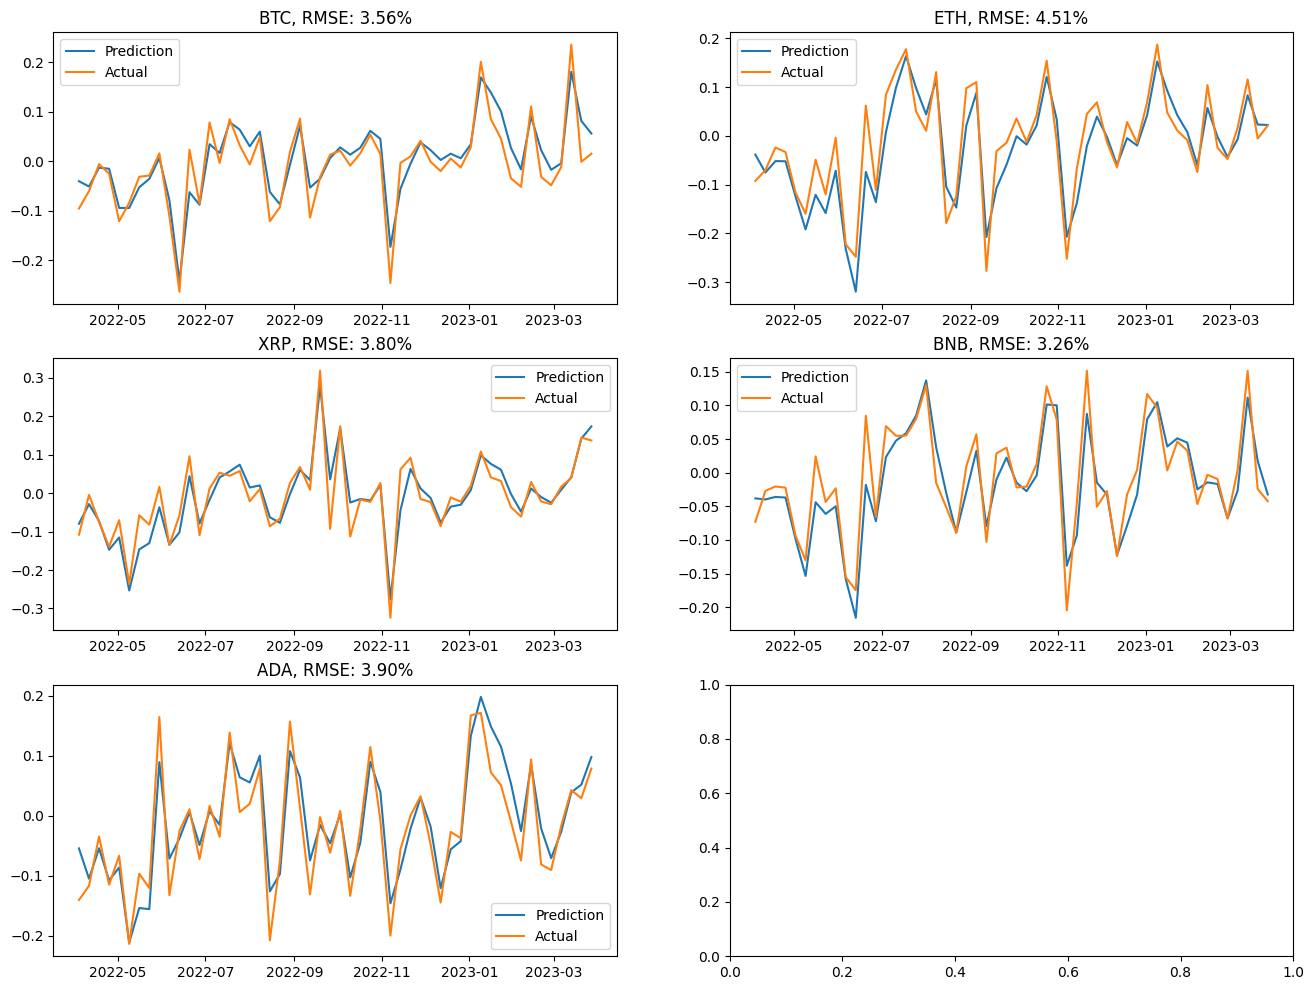

In [10]:
# Plot and evaluate
fig, axs = plt.subplots(3, 2, figsize = (16, 12))

for tick, ax in zip(ticks, axs.ravel()):
    plot_evaluate(test_dict[tick], tick, ax)

We can see here, that LSTM model performs quite well in estimating expected return with ~4% error across coins

room for improvements;
- Hyperoptimization on the LSTM structure
- Experimenting on different EMA(n) input. Possibly varying combinations of EMA(n) across coins.

In [67]:
df_mu = pd.DataFrame()

for tick in ticks:
    df_mu.index = test_dict[tick].index
    df_mu[f"{tick}_ret_pred"] = test_dict[tick][f"{tick}_ret_pred"]

df_mu.columns = [col.split('_')[0].upper() + "-USD" for col in df_mu.columns.tolist()]

mu_dict = {}

for date in df_mu.index.tolist():
    mu_dict[date] = pd.Series(df_mu[df_mu.index == date].iloc[0])

## 2.b. Expected Return (Baseline)

Historical average as expected return

In [12]:
def historical_ret(df, date):

    out_dict = {}
    dates = df[df.index > date].index.tolist()
    
    for date in dates:
        df_input = df[df.index < date].copy()
        avg_mean = df_input.mean()
        out_dict[date] = avg_mean
    
    return out_dict

In [13]:
# baseline expected return
mu_base_dict = historical_ret(df_ret[[col + '_ret' for col in ticks]], training_split_date)

# 3. Expected Covariance

Technically we can also build custom model for the expected covariance. Since covariance between two coins can be define as;
Cov(X,Y) = Corr(X,Y) * SD(X) * SD(Y) - E[X]E[Y]
We can build a volatility model with GARCH method for the SD & use rolling correlation for the corr coef component. Something to consider in the future.

In [14]:
# def pred_cov_matrix(df, date):

#     out_dict = {}
#     dates = temp[temp.index > date].index.tolist()
    
#     for date in dates:
#         df_input = df[df.index < date].copy()
#         cov = CovarianceShrinkage(df_input).ledoit_wolf()
#         out_dict[date] = cov

#     return out_dict

def historical_cov_matrix(df, date):

    out_dict = {}
    dates = df[df.index > date].index.tolist()
    
    for date in dates:
        df_input = df[df.index < date].copy()
        cov = df_input.cov()
        out_dict[date] = cov
    
    return out_dict

In [15]:
df_cov = df_ret[[f"{tick}_ret" for tick in ticks]].copy()
df_cov.columns = ["{}-USD".format(col.split('_')[0].upper()) for col in df_cov.columns]
cov_dict = historical_cov_matrix(df_cov, training_split_date)

# 4. Portfolio Optimization

Obj: Find optimal weights for each coins that maximize Sharpe ratio

Method: Randomized search simulation to find optimal weights (n = 10,000 per week)

Note: mu baseline is simple weekly average return

In [16]:
def find_weight(mu, cov, mu_base, n_simulations = 10000, n_assets = 5):

    w_cols = [col + "_w" for col in mu.index.tolist()]
    df_out = pd.DataFrame(columns = ['port_return', 'port_volatility', 'port_return_base'] + w_cols)

    for _ in range(n_simulations):
        weights = np.random.random(n_assets)
        weights = weights / weights.sum()

        row_dict = dict(zip(w_cols, weights))
        row_dict['port_return'] =  mu.dot(weights)
        row_dict['port_return_base'] = mu_base.dot(weights)
        row_dict['port_volatility'] = np.sqrt(np.transpose(weights)@cov@weights)
        df_out.loc[len(df_out)] = row_dict

    df_out['sharpe'] = df_out.port_return / df_out.port_volatility
    df_out['sharpe_base'] = df_out.port_return_base / df_out.port_volatility

    opt_w = df_out.iloc[df_out.sharpe.idxmax()][w_cols]
    opt_w_base = df_out.iloc[df_out.sharpe_base.idxmax()][w_cols]
    
    return dict(opt_w), dict(opt_w_base)

In [17]:
dates = test.index.tolist()
df_w = pd.DataFrame(columns = ['Date'] + [col + '_w' for col in tickers])
df_w_base = pd.DataFrame(columns = ['Date'] + [col + '_w' for col in tickers])

for date in dates:
    mu = mu_dict[date]
    cov = cov_dict[date]
    mu_base = mu_base_dict[date]

    opt_w, opt_w_base = find_weight(mu, cov, mu_base)
    opt_w['Date'], opt_w_base['Date'] = date, date

    df_w.loc[len(df_w)] = opt_w
    df_w_base.loc[len(df_w)] = opt_w_base

df_w = df_w.set_index('Date')
df_w_base = df_w_base.set_index('Date')

df_w_all = df_w.merge(df_w_base, left_index = True, right_index = True, suffixes = ('', '_base'))
df_w_all.head()

,BTC-USD_w,ETH-USD_w,XRP-USD_w,BNB-USD_w,ADA-USD_w,BTC-USD_w_base,ETH-USD_w_base,XRP-USD_w_base,BNB-USD_w_base,ADA-USD_w_base
Date,,,,,,,,,,
2022-04-04,0.142160,0.117107,0.010773,0.687635,0.042325,0.142160,0.117107,0.010773,0.687635,0.042325
2022-04-11,0.037176,0.092533,0.814316,0.043322,0.012653,0.155343,0.047649,0.065723,0.726805,0.004480
2022-04-18,0.829464,0.004980,0.013364,0.120910,0.031282,0.011690,0.108444,0.048732,0.775518,0.055617
2022-04-25,0.841070,0.005702,0.031416,0.108072,0.013740,0.065198,0.050470,0.023855,0.795918,0.064558
2022-05-02,0.080277,0.082697,0.009203,0.056855,0.770969,0.165943,0.047675,0.068143,0.688071,0.030168


We use Random Search technique in finding optimal weights. While it's straightforward, it is computationally heavy as number of assets goes up & only found the local optimum with small n of simulations. Hence, can explore other optimization technique (stochastic optimization, etc) to find the optimal weights.

# 5. Evaluation

**Metrics function:**
- Annualized Return = *(Final Port Value / Initial Port Value)^1/n - 1*, with n as number of year
- Volatility (Annualized) = *sigma * sqrt(n)*, with n as number of days in a year
- MDD = *(Min Port Value - Max Port Value) / Max Port Value*
- Win Rate = *# Win Trade / # Total Trade*
- Sharpe Ratio = *Annualized Return / Annualized Sigma*, assuming expected return equal to annualized return
- Sortino Ratio = *Annualized Retrun / Annualized Downward Sigma*, assuming expected return equal to annualized return

## 5.a. ML based portfolio vs Historical based portfolio

*Portfolio rebalanced weekly*

In [59]:
def port_return(row):
    ret = (row.btc_ret * row['BTC-USD_w']) + (row.eth_ret * row['ETH-USD_w']) + (row.xrp_ret * row['XRP-USD_w']) + (row.bnb_ret * row['BNB-USD_w']) + (row.ada_ret * row['ADA-USD_w'])

    return ret

def port_return_base(row):
    ret = (row.btc_ret * row['BTC-USD_w_base']) + (row.eth_ret * row['ETH-USD_w_base']) + (row.xrp_ret * row['XRP-USD_w_base']) + (row.bnb_ret * row['BNB-USD_w_base']) + (row.ada_ret * row['ADA-USD_w_base'])

    return ret

def port_return_equal(row):
    ret = (row.btc_ret * 0.2) + (row.eth_ret * 0.2) + (row.xrp_ret * 0.2) + (row.bnb_ret * 0.2) + (row.ada_ret * 0.2)

    return ret

def gen_metrics_report(df, port_col_suff = ''):

    # Annualized Return
    initial_portfolio_value = 1000
    final_portfolio_value = df['port_value' + port_col_suff].values[-1]
    annualized_return = (final_portfolio_value/initial_portfolio_value)**1/1 - 1

    # Volatility
    sigma = np.std(df['port_return' + port_col_suff])
    volatility = sigma * np.sqrt(52) # weekly to annual

    # MDD
    min_portfolio = df['port_value' + port_col_suff].min()
    max_portfolio = df['port_value' + port_col_suff].max()
    mdd = (min_portfolio - max_portfolio)/max_portfolio

    # Sharpe ratio
    sharpe_ratio = annualized_return / volatility # Assuming Rf is 0

    # Sortino ratio
    annualized_downside_sigma = np.std(df[df['port_return' + port_col_suff] < 0]['port_return' + port_col_suff]) * np.sqrt(52)
    sortino_ratio = annualized_return / annualized_downside_sigma

    idx = ['Return (Annualized)', 'Volatility (Annualized)', 'MDD', 'Sharpe Ratio', 'Sortino Ratio']
    val = [annualized_return, volatility, mdd, sharpe_ratio, sortino_ratio]

    return pd.Series(data = val, index = idx)


In [33]:
df_eval = test[[col + '_ret' for col in ticks]].copy()
df_eval = df_eval.merge(df_w_all, left_index = True, right_index = True)

df_eval['port_return'] = df_eval.apply(port_return, axis = 1)
df_eval['port_return_base'] = df_eval.apply(port_return_base, axis = 1)

df_eval_final = df_eval[[col + '_ret' for col in ticks] + ['port_return', 'port_return_base']].copy()
df_eval_final['port_return_cumsum'] = df_eval_final.port_return.cumsum()
df_eval_final['port_return_cumsum_base'] = df_eval_final.port_return_base.cumsum()
df_eval_final['port_value'] = df_eval_final.port_return_cumsum.apply(lambda x : 1000 * (1 + x)) # assume $1000 initial port value
df_eval_final['port_value_base'] = df_eval_final.port_return_cumsum_base.apply(lambda x : 1000 * (1 + x)) # assume $1000 initial port value

df_eval_final.head()

,btc_ret,eth_ret,xrp_ret,bnb_ret,ada_ret,port_return,port_return_base,port_return_cumsum,port_return_cumsum_base,port_value,port_value_base
Date,,,,,,,,,,,
2022-04-04,-0.095851,-0.092413,-0.108054,-0.073129,-0.140119,-0.081829,-0.081829,-0.081829,-0.081829,918.170827,918.170827
2022-04-11,-0.060824,-0.070441,-0.004584,-0.027153,-0.116557,-0.015163,-0.033363,-0.096992,-0.115192,903.007945,884.807673
2022-04-18,-0.006255,-0.023892,-0.074992,-0.020515,-0.034504,-0.009869,-0.024148,-0.106862,-0.139340,893.138492,860.660137
2022-04-25,-0.025668,-0.033036,-0.139359,-0.022356,-0.114644,-0.030146,-0.031860,-0.137008,-0.171200,862.992326,828.800166
2022-05-02,-0.121753,-0.116233,-0.070394,-0.093629,-0.066409,-0.076556,-0.096969,-0.213564,-0.268169,786.436072,731.830947


In [56]:
ml_port_metrics = gen_metrics_report(df_eval_final)
base_port_metrics = gen_metrics_report(df_eval_final, port_col_suff = '_base')

metrics_table = pd.DataFrame({'ml_based':ml_port_metrics, 'baseline':base_port_metrics})
metrics_table

,ml_based,baseline
Return (Annualized),1.488529,-0.463706
Volatility (Annualized),0.672762,0.576520
MDD,-0.778055,-0.813263
Sharpe Ratio,2.212565,-0.804319
Sortino Ratio,4.374780,-1.147353


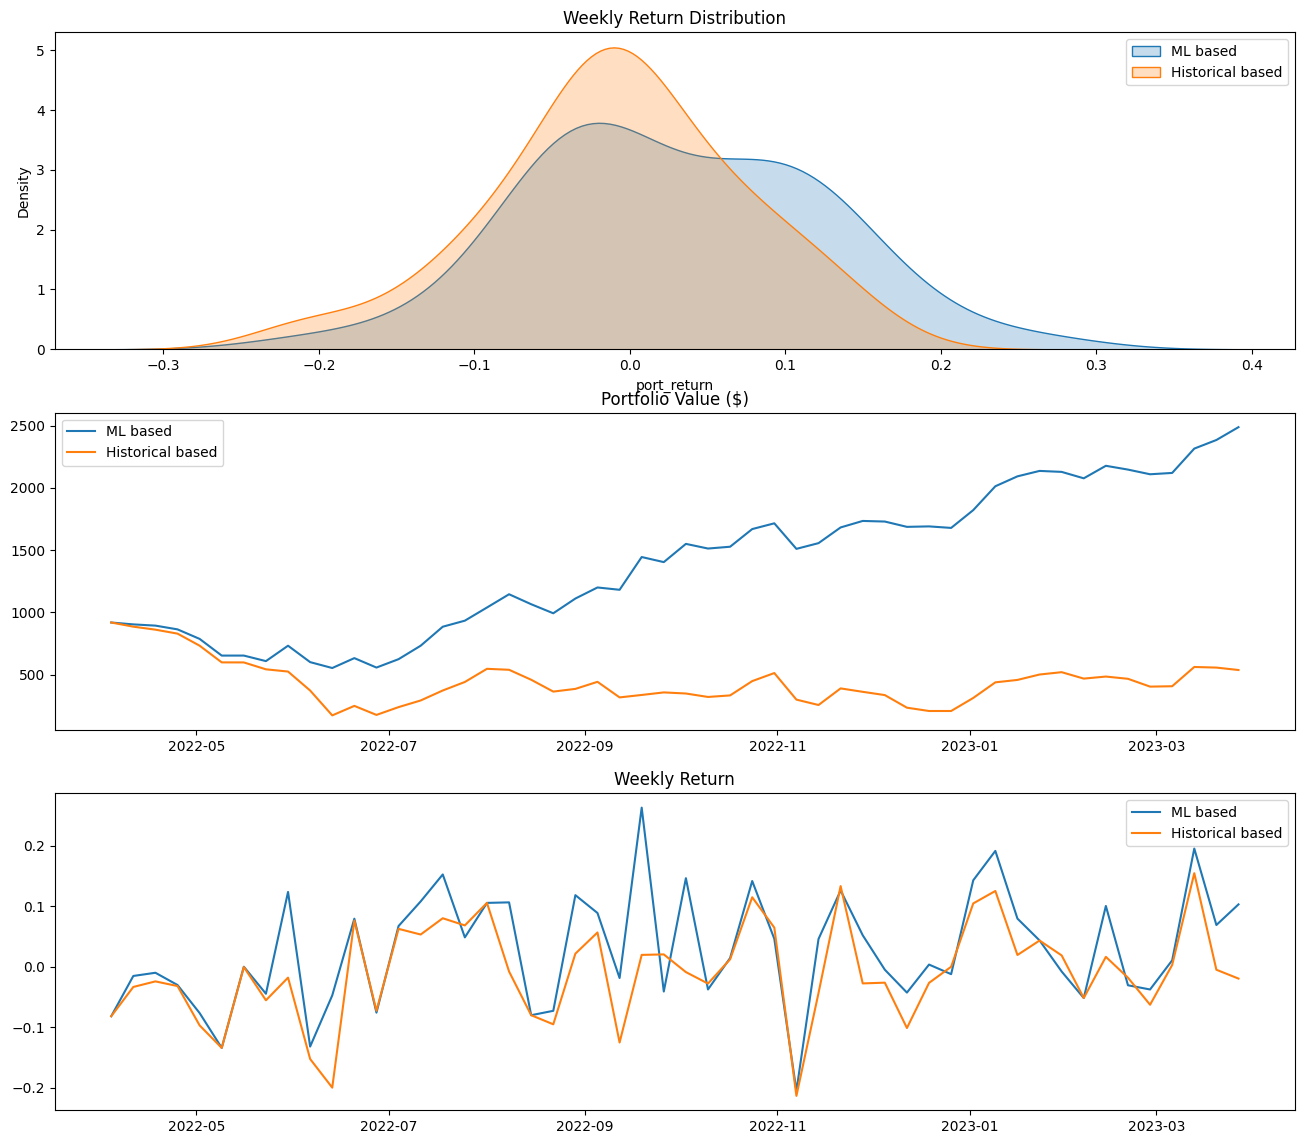

In [55]:
fig, ax = plt.subplots(3, 1, figsize = (16,14))

# Return Distribution
sns.kdeplot(df_eval_final['port_return'], ax = ax[0], fill = True, label = 'ML based')
sns.kdeplot(df_eval_final['port_return_base'], ax = ax[0], fill = True, label = 'Historical based')
ax[0].legend()
ax[0].title.set_text('Weekly Return Distribution')
ax[0].get_xaxis().set_visible(True)

# Equity Curve
ax[1].plot(df_eval_final.index, df_eval_final['port_value'], label = 'ML based')
ax[1].plot(df_eval_final.index, df_eval_final['port_value_base'], label = 'Historical based')
ax[1].legend()
ax[1].title.set_text('Portfolio Value ($)')

# Daily Return
ax[2].plot(df_eval_final.index, df_eval_final['port_return'], label = 'ML based')
ax[2].plot(df_eval_final.index, df_eval_final['port_return_base'], label = 'Historical based')
ax[2].legend()
ax[2].title.set_text('Weekly Return')

In [69]:
fig.savefig('assets/images/performance_comparison.jpg')

**Key Insights:**
- Historical based portfolio has central tendancy near 0 & slightly left-skewed. While the ML based portfolio has right-skewed ditribution. This indicates that the **weekly return of Ml based has more positive & higher return**.
- Portfolio value of both Ml based & Historical based started at similar level. However, somewhere around 2022-06, Ml based starts to outperform Historical based. Seeing at the details of the weight allocation, **Ml based has more optimal allocation** since some of the coins has started on bullish trend (invest more on positive expected return)

## 5.b. Compare with other traditional strategies

- Invest in each coins only
- Equal weighted portfolio

In [61]:
df_eval_other = df_eval_final.copy()

# Individual coins
for tick in ticks:
    df_eval_other[f"{tick}_return_cumsum"] = df_eval_other[f"{tick}_ret"]
    df_eval_other[f"port_value_{tick}"] = df_eval_other[f"{tick}_return_cumsum"].apply(lambda x : 1000 * (1 + x))

# Equal-weighted portfolio
df_eval_other['port_return_equal'] = df_eval_other.apply(port_return_equal, axis = 1)
df_eval_other['port_return_cumsum_equal'] = df_eval_other.port_return_equal.cumsum()
df_eval_other['port_value_equal'] = df_eval_other["port_return_cumsum_equal"].apply(lambda x : 1000 * (1 + x))

df_eval_other = df_eval_other.rename(columns = {'btc_ret':'port_return_btc', 'eth_ret':'port_return_eth', 'xrp_ret':'port_return_xrp', 'bnb_ret':'port_return_bnb', 'ada_ret':'port_return_ada'})
df_eval_other.head()

,port_return_btc,port_return_eth,port_return_xrp,port_return_bnb,port_return_ada,port_return,port_return_base,port_return_cumsum,port_return_cumsum_base,port_value,...,port_value_eth,xrp_return_cumsum,port_value_xrp,bnb_return_cumsum,port_value_bnb,ada_return_cumsum,port_value_ada,port_return_equal,port_return_cumsum_equal,port_value_equal
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-04,-0.095851,-0.092413,-0.108054,-0.073129,-0.140119,-0.081829,-0.081829,-0.081829,-0.081829,918.170827,...,907.586734,-0.108054,891.945627,-0.073129,926.870951,-0.140119,859.881102,-0.101913,-0.101913,898.086635
2022-04-11,-0.060824,-0.070441,-0.004584,-0.027153,-0.116557,-0.015163,-0.033363,-0.096992,-0.115192,903.007945,...,929.558604,-0.004584,995.416441,-0.027153,972.847289,-0.116557,883.442588,-0.055912,-0.157825,842.174844
2022-04-18,-0.006255,-0.023892,-0.074992,-0.020515,-0.034504,-0.009869,-0.024148,-0.106862,-0.139340,893.138492,...,976.108049,-0.074992,925.007575,-0.020515,979.484681,-0.034504,965.496374,-0.032032,-0.189857,810.143150
2022-04-25,-0.025668,-0.033036,-0.139359,-0.022356,-0.114644,-0.030146,-0.031860,-0.137008,-0.171200,862.992326,...,966.964478,-0.139359,860.640991,-0.022356,977.644024,-0.114644,885.356414,-0.067012,-0.256869,743.130768
2022-05-02,-0.121753,-0.116233,-0.070394,-0.093629,-0.066409,-0.076556,-0.096969,-0.213564,-0.268169,786.436072,...,883.766940,-0.070394,929.606494,-0.093629,906.370868,-0.066409,933.591162,-0.093684,-0.350553,649.447252


In [66]:
comparison_dict  = {}

port_list = ['', '_base', '_equal', '_btc', '_eth', '_xrp', '_bnb', '_ada']
port_name = ['ml_based', 'baseline', 'equal_weighted', 'btc_only', 'eth_only', 'xrp_only', 'bnb_only', 'ada_only']

for p_col, p_name in zip(port_list, port_name):
    comparison_dict[p_name] = gen_metrics_report(df_eval_other, port_col_suff = p_col)

metrics_table_other = pd.DataFrame(comparison_dict)
metrics_table_other

,ml_based,baseline,equal_weighted,btc_only,eth_only,xrp_only,bnb_only,ada_only
Return (Annualized),1.488529,-0.463706,-0.625906,0.014776,0.021276,0.137049,-0.042455,0.078632
Volatility (Annualized),0.672762,0.576520,0.578204,0.614070,0.772768,0.718435,0.573582,0.687733
MDD,-0.778055,-0.813263,-1.041272,-0.404095,-0.391168,-0.487484,-0.309236,-0.328340
Sharpe Ratio,2.212565,-0.804319,-1.082500,0.024062,0.027532,0.190760,-0.074017,0.114335
Sortino Ratio,4.374780,-1.147353,-1.546141,0.031090,0.036406,0.274170,-0.114615,0.186553


# 6. Conclusion

- We did found that **ML-based portfolio has far outperformed the historical-based portfolio** (along with other strategies such as equal-weighted & individual coins only)
- Main reason why it outperformed the baseline is because the **ML-based can estimate expected return of each coins quite accurately**. It is **very useful on the period where there is low covariance or correlation between assets** (period where some coins performed better than others)